## PCA extraction from Neurosynth

In [1]:
from neurosynth import meta, decode, network, Dataset # to work with the neurosynth dataset
import pandas
import os
import numpy as np
from matplotlib import pyplot as plt # to plot some things here
from sklearn.decomposition import PCA # to run PCA 
from sklearn.preprocessing import scale, MinMaxScaler # to scale PCA scores to be between 0 and 255, for visualization
from nilearn import plotting # to plot brain slices
import nilearn
import pickle # to load existing files
from scipy import spatial # to extract the convex hull

/home/matanm/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# to avoid running this command I pickled a local version of the output:
# dataset = pickle.load( open( "neurosynth-data/dataset.p", "rb" ) )

# the neurosynth database can be downloaded from https://github.com/neurosynth/neurosynth-data
dataset = Dataset('neurosynth-data/database.txt')

In [8]:
# this is a list of all neurosynth terms
terms = pandas.read_csv('neurosynth-data//analysis_filter_list.tsv',delimiter='\t')
# but we're only interested in the terms that are non-anatomical
terms_anatfilter = pandas.read_csv('..//data//neurosynth_terms_anatfilter.txt',delimiter='\t')

In [10]:
# only keep terms that have a 'keep' value of 1 and n 'anatmoical' value of 0
kept_terms_anatfilter = terms_anatfilter['term'][np.logical_and(terms_anatfilter['keep']==1, terms_anatfilter['anatomical']==0)]
# we will take these terms and find their location in a list that is ordered alphabetically
kept_terms = terms['term'][terms['keep']==1]
anatfilter_indices = [i for i,k in enumerate(list(kept_terms)) if k in list(kept_terms_anatfilter)]
kept_terms_anatfilter = kept_terms.iloc[anatfilter_indices]

In [66]:
# this step will take a few hours to run. It involves extracting and saving the brain map for each term.
maps = {}
for term in kept_terms:
    ids = dataset.get_studies(term)
    ma = meta.MetaAnalysis(dataset, ids)
    maps[term] = ma.images['association-test_z']
    ma.save_results(os.path.join('neurosynth-data','maps',term))

In [102]:
# and saving everything to one 2d array
concat_maps = np.vstack((maps[k] for k in maps.keys()))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [12]:
# concat_maps = pickle.load(open("neurosynth-data/concat_maps.p","rb"))

In [14]:
concat_maps_anatfilter = concat_maps[anatfilter_indices]

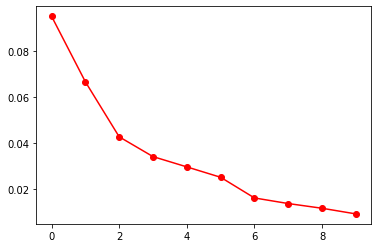

In [30]:
Apply PCA to the nonanatomical kept terms and print explained variance by component
pca = PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False).fit(concat_maps_anatfilter)
plt.plot(pca.explained_variance_ratio_, 'ro-') 

In [19]:
# save components
components = np.array([dataset.masker.unmask(pca.components_[i],output='array') for i in range(10)])
np.savez('../data/components',components)

In [20]:
# save the loadings of each term
term_weights = pca.transform(concat_maps)
np.savez('term_weights',term_weights)

In [25]:
# print ordered list of terms for the first component
kept_terms.iloc[term_weights[:,0].argsort()[::-1]]

1863                   motor
2264                premotor
1877               movements
2084                parietal
2265         premotor cortex
1876                movement
1305                    hand
1154                  finger
2882           supplementary
1043               execution
2286           primary motor
1865            motor cortex
2883     supplementary motor
1538           intraparietal
2631            sensorimotor
1867           motor imagery
1539    intraparietal sulcus
2935                   tasks
884          dorsal premotor
3144                  visual
2880       superior parietal
581            contralateral
393               cerebellum
2284                 primary
3118        ventral premotor
2871                  sulcus
1155        finger movements
1398                 imagery
90                    action
2740           somatosensory
                ...         
2011                     ofc
1879                    mpfc
2818                striatum
2440          

size(components)